In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import calendar


[*********************100%%**********************]  1 of 1 completed


Identified months with positive returns for at least 11 out of 15 years in training data:
['Jul', 'Oct']
Success rates in test data for identified months:
Jul: 100.00%
Oct: 60.00%
Overall success rate: 80.00%


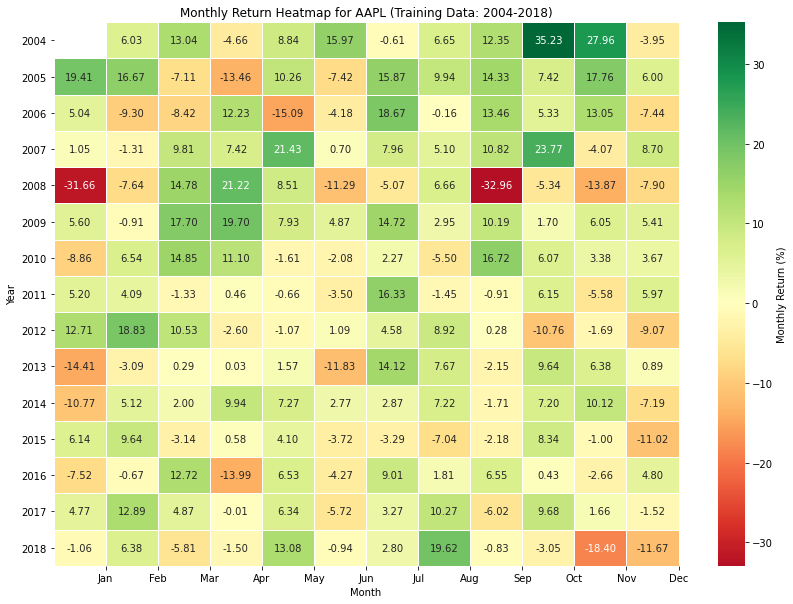

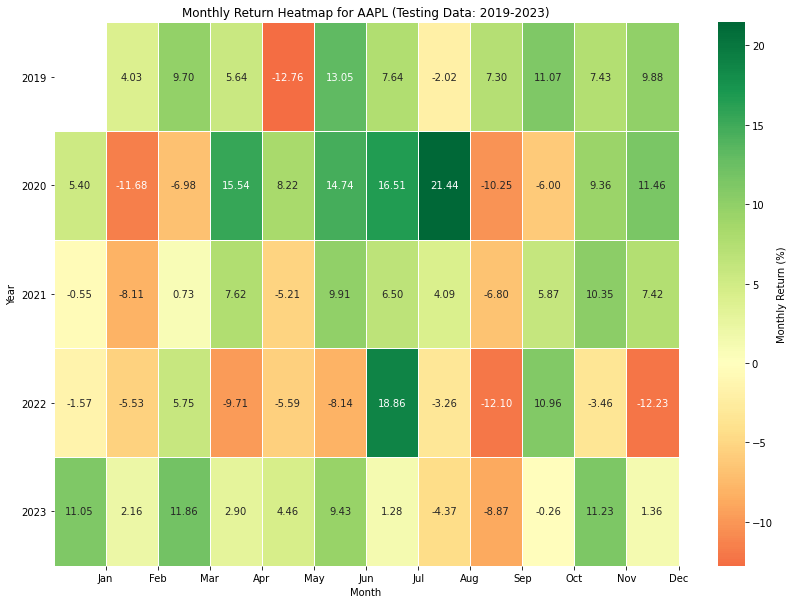

In [4]:
# Fetch maximum  period
ticker = "AAPL"
aapl_data = yf.download(ticker, period='max', interval='1d')

# Sagregation of Train and test data for the desired periods
train_data = aapl_data.loc[(aapl_data.index >= '2004-01-01') & (aapl_data.index <= '2018-12-31')].copy()
test_data = aapl_data.loc[(aapl_data.index >= '2019-01-01') & (aapl_data.index <= '2023-12-31')].copy()

# Calculate monthly percentage change in Close price for training data
train_data.loc[:, 'Month'] = train_data.index.to_period('M')
monthly_close_train = train_data['Close'].resample('M').last()
monthly_pct_change_train = monthly_close_train.pct_change() * 100

# Create pivot table for the heat map (training data)
monthly_pct_change_train_df = monthly_pct_change_train.to_frame(name='Monthly Return')
monthly_pct_change_train_df.loc[:, 'Year'] = monthly_pct_change_train_df.index.year
monthly_pct_change_train_df.loc[:, 'Month'] = monthly_pct_change_train_df.index.month

pivot_table_train = monthly_pct_change_train_df.pivot_table(values='Monthly Return', index='Year', columns='Month')

# Identify months with positive returns for at least 11 out of 15 years in training data
positive_counts_train = (pivot_table_train > 0).sum()
positive_months_train = positive_counts_train[positive_counts_train >= 12].index

# Calculate monthly percentage change in Close price for testing data
test_data.loc[:, 'Month'] = test_data.index.to_period('M')
monthly_close_test = test_data['Close'].resample('M').last()
monthly_pct_change_test = monthly_close_test.pct_change() * 100

# Create pivot table for the heat map (testing data)
monthly_pct_change_test_df = monthly_pct_change_test.to_frame(name='Monthly Return')
monthly_pct_change_test_df.loc[:, 'Year'] = monthly_pct_change_test_df.index.year
monthly_pct_change_test_df.loc[:, 'Month'] = monthly_pct_change_test_df.index.month

pivot_table_test = monthly_pct_change_test_df.pivot_table(values='Monthly Return', index='Year', columns='Month')

# Calculate success rate for identified months in the test data
success_rates = {}
for month in positive_months_train:
    positive_count_test = (pivot_table_test[month] > 0).sum()
    total_count_test = pivot_table_test[month].count()
    success_rate = (positive_count_test / total_count_test) * 100
    success_rates[calendar.month_abbr[month]] = success_rate

# Calculate overall success rate
overall_positive_count_test = (pivot_table_test[positive_months_train] > 0).sum().sum()
overall_total_count_test = pivot_table_test[positive_months_train].count().sum()
overall_success_rate = (overall_positive_count_test / overall_total_count_test) * 100

# Print results
print("Identified months with positive returns for at least 11 out of 15 years in training data:")
print([calendar.month_abbr[m] for m in positive_months_train])

print("Success rates in test data for identified months:")
for month, rate in success_rates.items():
    print(f"{month}: {rate:.2f}%")

print(f"Overall success rate: {overall_success_rate:.2f}%")

# Plotting the heat map for training data
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_train.loc[2004:2018], cmap='RdYlGn', annot=True, fmt=".2f", linewidths=.5, center=0, cbar_kws={'label': 'Monthly Return (%)'})
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)], rotation=0)
plt.yticks(rotation=0)
plt.title('Monthly Return Heatmap for AAPL (Training Data: 2004-2018)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# Plotting the heat map for testing data
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_test.loc[2019:2023], cmap='RdYlGn', annot=True, fmt=".2f", linewidths=.5, center=0, cbar_kws={'label': 'Monthly Return (%)'})
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)], rotation=0)
plt.yticks(rotation=0)
plt.title('Monthly Return Heatmap for AAPL (Testing Data: 2019-2023)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()
